In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (False for real tokens, True for padding)
        # This matches the convention used in transformers where
        # True indicates positions that should be masked
        padding_mask = torch.zeros(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = True
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([32, 277])
torch.Size([32, 277])
tensor([151,  88,  58, 115,  30,  88,  83,  40,  33,  69,  39,  67,  82,  26,
         83,  71,  79,  87,  81,  93,  99,  88,  27,  95,  71,  21,  25,  41,
         43,  98,  71,  87])

Vocabulary size: 519


In [4]:
import importlib
import cdcdModel
import scheduler
importlib.reload(cdcdModel)
importlib.reload(scheduler)

from cdcdModel import CDCDModel
from scheduler import AdaptiveSchedule

In [5]:
def train_step(model, batch, scheduler, optimizer):
    """Single training step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing:
            - input_ids: [batch_size, seq_len] tensor of token ids
            - padding_mask: [batch_size, seq_len] boolean tensor (True for padding)
        scheduler: AdaptiveSchedule instance
        optimizer: PyTorch optimizer
    
    Returns:
        loss: scalar training loss
        entropy: entropy statistics for scheduler
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=True,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Expand timesteps to match sequence dimension
        timesteps_expanded = timesteps.unsqueeze(-1).expand(-1, seq_len)
        
        # Add entropy data to scheduler (excluding padding)
        scheduler.add_data(
            entropy[~padding_mask],
            timesteps_expanded[~padding_mask],
            padding_mask=None  # Already filtered padding
        )
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.mean().item()

def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Use middle timestep for evaluation (or could sample uniformly)
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=False,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [7]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    initial_lr=1e-4,
    min_lr=1e-6,
    first_cycle_epochs=30,
    cycle_mult=2,
    eval_every=1,
    early_stopping_patience=5,
    save_dir="checkpoints",
    device="cuda",
):
    """Trains the CDCD model using Cosine Annealing with Warm Restarts
    
    Args:
        model: CDCDModel instance
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        noise_scheduler: Noise scheduler for diffusion process
        num_epochs: Number of epochs to train for
        initial_lr: Initial learning rate
        min_lr: Minimum learning rate
        first_cycle_epochs: Length of first cosine cycle
        cycle_mult: Factor to multiply cycle length by after each restart
        eval_every: Number of epochs between evaluation runs
        early_stopping_patience: Number of epochs to wait for improvement before stopping
        save_dir: Directory to save model checkpoints
        device: Device to train on
    """
    import torch
    from torch.optim import lr_scheduler
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
    lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=first_cycle_epochs,
        T_mult=cycle_mult,
        eta_min=min_lr
    )
    
    best_eval_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        train_losses.append(train_metrics['loss'])
        
        # Evaluation phase
        if (epoch + 1) % eval_every == 0:
            eval_metrics = run_epoch(
                model=model,
                dataloader=eval_dataloader,
                scheduler=noise_scheduler,
                optimizer=optimizer,
                train_run=False,
                epoch_num=epoch+1
            )
            eval_losses.append(eval_metrics['loss'])
            
            # Save best model and handle early stopping
            if eval_metrics['loss'] < best_eval_loss:
                best_eval_loss = eval_metrics['loss']
                best_epoch = epoch
                epochs_without_improvement = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': lr_scheduler.state_dict(),
                    'noise_scheduler_state': noise_scheduler.state_dict(),
                    'loss': best_eval_loss,
                }, save_dir / 'best_model.pt')
            else:
                epochs_without_improvement += 1
            print('-'*16)
            print(f"Eval Loss: {eval_metrics['loss']:.4f}")
            print(f"Best Loss: {best_eval_loss:.4f} (Epoch {best_epoch+1})")
            
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
        
        # Update learning rate
        lr_scheduler.step()
        learning_rates.append(current_lr)
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'noise_scheduler_state': noise_scheduler.state_dict(),
                'loss': train_metrics['loss'],
            }, save_dir / f'checkpoint_epoch_{epoch+1}.pt')
    
    # Load best model
    best_checkpoint = torch.load(save_dir / 'best_model.pt')
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'best_epoch': best_epoch,
        'learning_rates': learning_rates
    }

In [27]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings
num_heads = 16  # Number of attention heads
num_layers = 4  # Number of transformer layers
time_embed_dim = 16  # Dimension of time embeddings
t_min = 1 # Minimum time value
t_max = 25  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519

model = CDCDModel(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    num_layers = num_layers,
    time_embed_dim = time_embed_dim,
    t_min = t_min,
    t_max = t_max,
    vocab_size = vocab_size,
    dropout=0.1,
    pad_token_id=0
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 12.5,
    sigma = 8,
    height = 1,
    offset = 0.1
)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [29]:

for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [46]:
model.self_conditioner.prev_preds = None

In [47]:
training_history = train(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=60,
    initial_lr=1e-3,
    min_lr=1e-8,
    first_cycle_epochs=8,  # Length of first cosine cycle
    cycle_mult=2,  # Each subsequent cycle is twice as long
    eval_every=1,
    early_stopping_patience=20,
    save_dir="checkpoints"
)































































































Epoch 1 Loss: 3.4992, Entropy: 5.2677: 100%|██████████| 203/203 [00:08<00:00, 23.33it/s]
2025-02-12 12:10:11,159 - INFO - Updated optimal parameters: mu=1.6824857103417443, sigma=1.3079494040111845, height=7.0700066236887755, offset=-1.1982058673217226

























































Epoch 1 Loss: 3.3545, Entropy: 5.1435: 100%|██████████| 51/51 [00:00<00:00, 89.76it/s]


----------------
Eval Loss: 3.3545
Best Loss: 3.3545 (Epoch 1)

Epoch 2/60 - Learning Rate: 0.000962

















































































































































































































































































Epoch 2 Loss: 3.4286, Entropy: 5.2363: 100%|██████████| 203/203 [00:08<00:00, 23.43it/s]
2025-02-12 12:10:20,434 - INFO - Updated optimal parameters: mu=1.5482163548762835, sigma=1.3931073103160292, height=7.216832974568515, offset=-1.4164476727340618

























































Epoch 2 Loss: 3.4458, Entropy: 5.1311: 100%|██████████| 51/51 [00:00<00:00, 90.20it/s]


----------------
Eval Loss: 3.4458
Best Loss: 3.3545 (Epoch 1)

Epoch 3/60 - Learning Rate: 0.000854

















































































































































































































































































Epoch 3 Loss: 3.4671, Entropy: 5.2322: 100%|██████████| 203/203 [00:08<00:00, 23.41it/s]
2025-02-12 12:10:29,694 - INFO - Updated optimal parameters: mu=1.5223840275480613, sigma=1.3438323090673252, height=7.56525519132027, offset=-1.6823788744895922

























































Epoch 3 Loss: 3.3473, Entropy: 5.1029: 100%|██████████| 51/51 [00:00<00:00, 89.37it/s]


----------------
Eval Loss: 3.3473
Best Loss: 3.3473 (Epoch 3)

Epoch 4/60 - Learning Rate: 0.000691

















































































































































































































































































Epoch 4 Loss: 3.3775, Entropy: 5.2026: 100%|██████████| 203/203 [00:08<00:00, 23.37it/s]
2025-02-12 12:10:39,024 - INFO - Updated optimal parameters: mu=1.6597856351436329, sigma=1.4115530142726778, height=7.3075913006696105, offset=-1.3988226634003111

























































Epoch 4 Loss: 3.3896, Entropy: 5.0966: 100%|██████████| 51/51 [00:00<00:00, 88.68it/s]


----------------
Eval Loss: 3.3896
Best Loss: 3.3473 (Epoch 3)

Epoch 5/60 - Learning Rate: 0.000500

















































































































































































































































































Epoch 5 Loss: 3.4843, Entropy: 5.2216: 100%|██████████| 203/203 [00:08<00:00, 23.38it/s]
2025-02-12 12:10:48,303 - INFO - Updated optimal parameters: mu=1.620872320556289, sigma=1.3575422861344275, height=7.471195407886051, offset=-1.639306585964559

























































Epoch 5 Loss: 3.4203, Entropy: 5.1093: 100%|██████████| 51/51 [00:00<00:00, 89.48it/s]


----------------
Eval Loss: 3.4203
Best Loss: 3.3473 (Epoch 3)

Epoch 6/60 - Learning Rate: 0.000309

















































































































































































































































































Epoch 6 Loss: 3.3642, Entropy: 5.1925: 100%|██████████| 203/203 [00:08<00:00, 23.40it/s]
2025-02-12 12:10:57,570 - INFO - Updated optimal parameters: mu=1.669576634403497, sigma=1.5740089523010885, height=7.663116028112051, offset=-1.6580847288643648

























































Epoch 6 Loss: 3.5047, Entropy: 5.1291: 100%|██████████| 51/51 [00:00<00:00, 90.17it/s]


----------------
Eval Loss: 3.5047
Best Loss: 3.3473 (Epoch 3)

Epoch 7/60 - Learning Rate: 0.000146

















































































































































































































































































Epoch 7 Loss: 3.5462, Entropy: 5.2320: 100%|██████████| 203/203 [00:08<00:00, 23.44it/s]
2025-02-12 12:11:06,816 - INFO - Updated optimal parameters: mu=1.5476408868242468, sigma=1.4427636919324143, height=7.740768452422858, offset=-1.8439308560634995

























































Epoch 7 Loss: 3.4701, Entropy: 5.1169: 100%|██████████| 51/51 [00:00<00:00, 90.30it/s]


----------------
Eval Loss: 3.4701
Best Loss: 3.3473 (Epoch 3)

Epoch 8/60 - Learning Rate: 0.000038

















































































































































































































































































Epoch 8 Loss: 3.4196, Entropy: 5.2044: 100%|██████████| 203/203 [00:08<00:00, 23.43it/s]
2025-02-12 12:11:16,062 - INFO - Updated optimal parameters: mu=1.7615011199891686, sigma=1.4916218637684302, height=7.233993660370539, offset=-1.2612950656229738

























































Epoch 8 Loss: 3.5531, Entropy: 5.1451: 100%|██████████| 51/51 [00:00<00:00, 89.32it/s]


----------------
Eval Loss: 3.5531
Best Loss: 3.3473 (Epoch 3)

Epoch 9/60 - Learning Rate: 0.001000

















































































































































































































































































Epoch 9 Loss: 3.5463, Entropy: 5.2288: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:11:25,307 - INFO - Updated optimal parameters: mu=1.7055880233511096, sigma=1.5051299541925625, height=7.576317972795768, offset=-1.5892003780990225

























































Epoch 9 Loss: 3.4792, Entropy: 5.1388: 100%|██████████| 51/51 [00:00<00:00, 89.40it/s]


----------------
Eval Loss: 3.4792
Best Loss: 3.3473 (Epoch 3)

Epoch 10/60 - Learning Rate: 0.000990

















































































































































































































































































Epoch 10 Loss: 3.5425, Entropy: 5.2190: 100%|██████████| 203/203 [00:08<00:00, 23.45it/s]
2025-02-12 12:11:34,552 - INFO - Updated optimal parameters: mu=1.4696093548436215, sigma=1.5243519521807218, height=7.694416370328116, offset=-1.7437077027733667

























































Epoch 10 Loss: 3.4836, Entropy: 5.1215: 100%|██████████| 51/51 [00:00<00:00, 89.92it/s]


----------------
Eval Loss: 3.4836
Best Loss: 3.3473 (Epoch 3)

Epoch 11/60 - Learning Rate: 0.000962

















































































































































































































































































Epoch 11 Loss: 3.4774, Entropy: 5.1951: 100%|██████████| 203/203 [00:08<00:00, 23.33it/s]
2025-02-12 12:11:43,872 - INFO - Updated optimal parameters: mu=1.5770839815948965, sigma=1.481097677471029, height=7.948207058241141, offset=-1.9683812620340595

























































Epoch 11 Loss: 3.4865, Entropy: 5.0899: 100%|██████████| 51/51 [00:00<00:00, 89.60it/s]


----------------
Eval Loss: 3.4865
Best Loss: 3.3473 (Epoch 3)

Epoch 12/60 - Learning Rate: 0.000916

















































































































































































































































































Epoch 12 Loss: 3.4435, Entropy: 5.1735: 100%|██████████| 203/203 [00:08<00:00, 23.21it/s]
2025-02-12 12:11:53,206 - INFO - Updated optimal parameters: mu=1.6525707712689672, sigma=1.3726989147690827, height=7.884782761096588, offset=-1.907669636114374

























































Epoch 12 Loss: 3.4188, Entropy: 5.0537: 100%|██████████| 51/51 [00:00<00:00, 89.91it/s]


----------------
Eval Loss: 3.4188
Best Loss: 3.3473 (Epoch 3)

Epoch 13/60 - Learning Rate: 0.000854

















































































































































































































































































Epoch 13 Loss: 3.4255, Entropy: 5.1643: 100%|██████████| 203/203 [00:08<00:00, 23.17it/s]
2025-02-12 12:12:02,550 - INFO - Updated optimal parameters: mu=1.6148332601406046, sigma=1.332823753794225, height=7.62958519497652, offset=-1.7396692392345448

























































Epoch 13 Loss: 3.3208, Entropy: 5.0420: 100%|██████████| 51/51 [00:00<00:00, 89.99it/s]


----------------
Eval Loss: 3.3208
Best Loss: 3.3208 (Epoch 13)

Epoch 14/60 - Learning Rate: 0.000778

















































































































































































































































































Epoch 14 Loss: 3.3415, Entropy: 5.1379: 100%|██████████| 203/203 [00:08<00:00, 23.16it/s]
2025-02-12 12:12:11,919 - INFO - Updated optimal parameters: mu=1.6090054883557086, sigma=1.486139458854417, height=7.577410213961963, offset=-1.6757539192636004

























































Epoch 14 Loss: 3.4701, Entropy: 5.0545: 100%|██████████| 51/51 [00:00<00:00, 90.06it/s]


----------------
Eval Loss: 3.4701
Best Loss: 3.3208 (Epoch 13)

Epoch 15/60 - Learning Rate: 0.000691

















































































































































































































































































Epoch 15 Loss: 3.4434, Entropy: 5.1546: 100%|██████████| 203/203 [00:08<00:00, 23.34it/s]
2025-02-12 12:12:21,203 - INFO - Updated optimal parameters: mu=1.6556945749936014, sigma=1.5549635932594652, height=7.8205985249714445, offset=-1.7986565517035182

























































Epoch 15 Loss: 3.5453, Entropy: 5.0819: 100%|██████████| 51/51 [00:00<00:00, 90.03it/s]


----------------
Eval Loss: 3.5453
Best Loss: 3.3208 (Epoch 13)

Epoch 16/60 - Learning Rate: 0.000598

















































































































































































































































































Epoch 16 Loss: 3.4705, Entropy: 5.1583: 100%|██████████| 203/203 [00:08<00:00, 23.32it/s]
2025-02-12 12:12:30,491 - INFO - Updated optimal parameters: mu=1.577203202996512, sigma=1.5325965537369353, height=7.8398489787502035, offset=-1.8770737883876483

























































Epoch 16 Loss: 3.4631, Entropy: 5.0619: 100%|██████████| 51/51 [00:00<00:00, 90.44it/s]


----------------
Eval Loss: 3.4631
Best Loss: 3.3208 (Epoch 13)

Epoch 17/60 - Learning Rate: 0.000500

















































































































































































































































































Epoch 17 Loss: 3.4183, Entropy: 5.1455: 100%|██████████| 203/203 [00:08<00:00, 23.33it/s]
2025-02-12 12:12:39,773 - INFO - Updated optimal parameters: mu=1.575380667905806, sigma=1.5727123466724793, height=7.914700796389442, offset=-1.9241694819196866

























































Epoch 17 Loss: 3.5125, Entropy: 5.0815: 100%|██████████| 51/51 [00:00<00:00, 90.21it/s]


----------------
Eval Loss: 3.5125
Best Loss: 3.3208 (Epoch 13)

Epoch 18/60 - Learning Rate: 0.000402

















































































































































































































































































Epoch 18 Loss: 3.4580, Entropy: 5.1528: 100%|██████████| 203/203 [00:08<00:00, 23.31it/s]
2025-02-12 12:12:49,072 - INFO - Updated optimal parameters: mu=1.7463638479886432, sigma=1.087828036914119, height=6.737685773873031, offset=-1.069724160468055

























































Epoch 18 Loss: 3.3191, Entropy: 5.0039: 100%|██████████| 51/51 [00:00<00:00, 89.92it/s]


----------------
Eval Loss: 3.3191
Best Loss: 3.3191 (Epoch 18)

Epoch 19/60 - Learning Rate: 0.000309

















































































































































































































































































Epoch 19 Loss: 3.1988, Entropy: 5.0924: 100%|██████████| 203/203 [00:08<00:00, 23.32it/s]
2025-02-12 12:12:58,393 - INFO - Updated optimal parameters: mu=1.8047592464512654, sigma=1.4851330627987076, height=7.10163615207226, offset=-1.194786475841197

























































Epoch 19 Loss: 3.5055, Entropy: 5.0634: 100%|██████████| 51/51 [00:00<00:00, 89.96it/s]


----------------
Eval Loss: 3.5055
Best Loss: 3.3191 (Epoch 18)

Epoch 20/60 - Learning Rate: 0.000222

















































































































































































































































































Epoch 20 Loss: 3.4915, Entropy: 5.1555: 100%|██████████| 203/203 [00:08<00:00, 23.30it/s]
2025-02-12 12:13:07,692 - INFO - Updated optimal parameters: mu=1.741275774483595, sigma=1.4520897772219155, height=7.487720514107938, offset=-1.5564774896696723

























































Epoch 20 Loss: 3.5034, Entropy: 5.0609: 100%|██████████| 51/51 [00:00<00:00, 89.91it/s]


----------------
Eval Loss: 3.5034
Best Loss: 3.3191 (Epoch 18)

Epoch 21/60 - Learning Rate: 0.000146

















































































































































































































































































Epoch 21 Loss: 3.4191, Entropy: 5.1409: 100%|██████████| 203/203 [00:08<00:00, 23.38it/s]
2025-02-12 12:13:16,986 - INFO - Updated optimal parameters: mu=1.688202553476476, sigma=1.4197550843948021, height=7.525514551273527, offset=-1.6566790260351598

























































Epoch 21 Loss: 3.4593, Entropy: 5.0525: 100%|██████████| 51/51 [00:00<00:00, 90.07it/s]


----------------
Eval Loss: 3.4593
Best Loss: 3.3191 (Epoch 18)

Epoch 22/60 - Learning Rate: 0.000084

















































































































































































































































































Epoch 22 Loss: 3.3800, Entropy: 5.1308: 100%|██████████| 203/203 [00:08<00:00, 23.44it/s]
2025-02-12 12:13:26,230 - INFO - Updated optimal parameters: mu=1.712529054634916, sigma=1.409345459090275, height=7.587386949458568, offset=-1.6749860926206956

























































Epoch 22 Loss: 3.4167, Entropy: 5.0371: 100%|██████████| 51/51 [00:00<00:00, 90.41it/s]


----------------
Eval Loss: 3.4167
Best Loss: 3.3191 (Epoch 18)

Epoch 23/60 - Learning Rate: 0.000038

















































































































































































































































































Epoch 23 Loss: 3.3530, Entropy: 5.1253: 100%|██████████| 203/203 [00:08<00:00, 23.47it/s]
2025-02-12 12:13:35,463 - INFO - Updated optimal parameters: mu=1.614198938049198, sigma=1.2743099543343357, height=7.4737902339273825, offset=-1.6630314963511013

























































Epoch 23 Loss: 3.3119, Entropy: 5.0077: 100%|██████████| 51/51 [00:00<00:00, 89.87it/s]


----------------
Eval Loss: 3.3119
Best Loss: 3.3119 (Epoch 23)

Epoch 24/60 - Learning Rate: 0.000010

















































































































































































































































































Epoch 24 Loss: 3.2783, Entropy: 5.1104: 100%|██████████| 203/203 [00:08<00:00, 23.48it/s]
2025-02-12 12:13:44,719 - INFO - Updated optimal parameters: mu=1.7271012966097552, sigma=1.4560313116828267, height=7.475031332195508, offset=-1.5897957205553517

























































Epoch 24 Loss: 3.4961, Entropy: 5.0669: 100%|██████████| 51/51 [00:00<00:00, 89.79it/s]


----------------
Eval Loss: 3.4961
Best Loss: 3.3119 (Epoch 23)

Epoch 25/60 - Learning Rate: 0.001000

















































































































































































































































































Epoch 25 Loss: 3.4498, Entropy: 5.1406: 100%|██████████| 203/203 [00:08<00:00, 23.48it/s]
2025-02-12 12:13:53,950 - INFO - Updated optimal parameters: mu=1.694943636916937, sigma=1.4892741323406646, height=7.607522314794097, offset=-1.6666219594919471

























































Epoch 25 Loss: 3.4662, Entropy: 5.0197: 100%|██████████| 51/51 [00:00<00:00, 88.98it/s]


----------------
Eval Loss: 3.4662
Best Loss: 3.3119 (Epoch 23)

Epoch 26/60 - Learning Rate: 0.000998

















































































































































































































































































Epoch 26 Loss: 3.4219, Entropy: 5.1269: 100%|██████████| 203/203 [00:08<00:00, 23.44it/s]
2025-02-12 12:14:03,204 - INFO - Updated optimal parameters: mu=1.6048449835136207, sigma=1.2655200640012267, height=7.494605453881747, offset=-1.745688988429727

























































Epoch 26 Loss: 3.3222, Entropy: 5.0144: 100%|██████████| 51/51 [00:00<00:00, 89.52it/s]


----------------
Eval Loss: 3.3222
Best Loss: 3.3119 (Epoch 23)

Epoch 27/60 - Learning Rate: 0.000990

















































































































































































































































































Epoch 27 Loss: 3.2407, Entropy: 5.0722: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:14:12,442 - INFO - Updated optimal parameters: mu=1.7185979130175266, sigma=1.4558540179927755, height=7.458629194781261, offset=-1.592935757038561

























































Epoch 27 Loss: 3.3996, Entropy: 4.9961: 100%|██████████| 51/51 [00:00<00:00, 89.88it/s]


----------------
Eval Loss: 3.3996
Best Loss: 3.3119 (Epoch 23)

Epoch 28/60 - Learning Rate: 0.000978

















































































































































































































































































Epoch 28 Loss: 3.4008, Entropy: 5.0952: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:14:21,682 - INFO - Updated optimal parameters: mu=1.689640886768998, sigma=1.4531791706872847, height=7.576317221120995, offset=-1.6685994511165827

























































Epoch 28 Loss: 3.4558, Entropy: 5.0040: 100%|██████████| 51/51 [00:00<00:00, 90.03it/s]


----------------
Eval Loss: 3.4558
Best Loss: 3.3119 (Epoch 23)

Epoch 29/60 - Learning Rate: 0.000962

















































































































































































































































































Epoch 29 Loss: 3.3950, Entropy: 5.0878: 100%|██████████| 203/203 [00:08<00:00, 23.47it/s]
2025-02-12 12:14:30,914 - INFO - Updated optimal parameters: mu=1.6868372455787481, sigma=1.4246253638468824, height=7.645361580382741, offset=-1.71297357494778

























































Epoch 29 Loss: 3.4352, Entropy: 4.9862: 100%|██████████| 51/51 [00:00<00:00, 90.31it/s]


----------------
Eval Loss: 3.4352
Best Loss: 3.3119 (Epoch 23)

Epoch 30/60 - Learning Rate: 0.000941

















































































































































































































































































Epoch 30 Loss: 3.3523, Entropy: 5.0707: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:14:40,147 - INFO - Updated optimal parameters: mu=1.6768771215189946, sigma=1.5412316438289084, height=7.641484618891092, offset=-1.706737874139035

























































Epoch 30 Loss: 3.5003, Entropy: 5.0022: 100%|██████████| 51/51 [00:00<00:00, 90.24it/s]


----------------
Eval Loss: 3.5003
Best Loss: 3.3119 (Epoch 23)

Epoch 31/60 - Learning Rate: 0.000916

















































































































































































































































































Epoch 31 Loss: 3.4609, Entropy: 5.0886: 100%|██████████| 203/203 [00:08<00:00, 23.47it/s]
2025-02-12 12:14:49,442 - INFO - Updated optimal parameters: mu=1.6617010079904015, sigma=1.5651135569616454, height=7.79849220730698, offset=-1.8079061725852974

























































Epoch 31 Loss: 3.5011, Entropy: 5.0016: 100%|██████████| 51/51 [00:00<00:00, 90.11it/s]


----------------
Eval Loss: 3.5011
Best Loss: 3.3119 (Epoch 23)

Epoch 32/60 - Learning Rate: 0.000887

















































































































































































































































































Epoch 32 Loss: 3.4476, Entropy: 5.0837: 100%|██████████| 203/203 [00:08<00:00, 23.45it/s]
2025-02-12 12:14:58,681 - INFO - Updated optimal parameters: mu=1.7478687456258628, sigma=1.3955989109556604, height=7.421548458881769, offset=-1.5228098287884957

























































Epoch 32 Loss: 3.4928, Entropy: 5.0082: 100%|██████████| 51/51 [00:00<00:00, 89.28it/s]


----------------
Eval Loss: 3.4928
Best Loss: 3.3119 (Epoch 23)

Epoch 33/60 - Learning Rate: 0.000854

















































































































































































































































































Epoch 33 Loss: 3.3654, Entropy: 5.0593: 100%|██████████| 203/203 [00:08<00:00, 23.40it/s]
2025-02-12 12:15:07,944 - INFO - Updated optimal parameters: mu=1.7565610611647906, sigma=1.44958870210809, height=7.43722043908081, offset=-1.591752201451933

























































Epoch 33 Loss: 3.4398, Entropy: 4.9975: 100%|██████████| 51/51 [00:00<00:00, 90.24it/s]


----------------
Eval Loss: 3.4398
Best Loss: 3.3119 (Epoch 23)

Epoch 34/60 - Learning Rate: 0.000817

















































































































































































































































































Epoch 34 Loss: 3.3656, Entropy: 5.0542: 100%|██████████| 203/203 [00:08<00:00, 23.24it/s]
2025-02-12 12:15:17,265 - INFO - Updated optimal parameters: mu=1.6736811344853153, sigma=1.670295003662642, height=7.564034886462414, offset=-1.6333332187310545

























































Epoch 34 Loss: 3.5927, Entropy: 5.0195: 100%|██████████| 51/51 [00:00<00:00, 90.05it/s]


----------------
Eval Loss: 3.5927
Best Loss: 3.3119 (Epoch 23)

Epoch 35/60 - Learning Rate: 0.000778

















































































































































































































































































Epoch 35 Loss: 3.5144, Entropy: 5.0837: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:15:26,507 - INFO - Updated optimal parameters: mu=1.7005457911090336, sigma=1.533303804578302, height=7.809112563687598, offset=-1.8885706634342465

























































Epoch 35 Loss: 3.4380, Entropy: 4.9793: 100%|██████████| 51/51 [00:00<00:00, 89.79it/s]


----------------
Eval Loss: 3.4380
Best Loss: 3.3119 (Epoch 23)

Epoch 36/60 - Learning Rate: 0.000736

















































































































































































































































































Epoch 36 Loss: 3.4449, Entropy: 5.0672: 100%|██████████| 203/203 [00:08<00:00, 23.45it/s]
2025-02-12 12:15:35,751 - INFO - Updated optimal parameters: mu=1.8573032627878718, sigma=1.2833222570439884, height=6.92995465220732, offset=-1.1702072333939768

























































Epoch 36 Loss: 3.4593, Entropy: 4.9906: 100%|██████████| 51/51 [00:00<00:00, 89.86it/s]


----------------
Eval Loss: 3.4593
Best Loss: 3.3119 (Epoch 23)

Epoch 37/60 - Learning Rate: 0.000691

















































































































































































































































































Epoch 37 Loss: 3.3359, Entropy: 5.0379: 100%|██████████| 203/203 [00:08<00:00, 23.45it/s]
2025-02-12 12:15:44,993 - INFO - Updated optimal parameters: mu=2.020889516043236, sigma=1.43267091816297, height=6.718474589453828, offset=-0.8867187987544155

























































Epoch 37 Loss: 3.5582, Entropy: 4.9913: 100%|██████████| 51/51 [00:00<00:00, 88.87it/s]


----------------
Eval Loss: 3.5582
Best Loss: 3.3119 (Epoch 23)

Epoch 38/60 - Learning Rate: 0.000645

















































































































































































































































































Epoch 38 Loss: 3.4814, Entropy: 5.0669: 100%|██████████| 203/203 [00:08<00:00, 23.44it/s]
2025-02-12 12:15:54,248 - INFO - Updated optimal parameters: mu=1.8046811018832485, sigma=1.35916977427874, height=7.14714068010315, offset=-1.318836711336889

























































Epoch 38 Loss: 3.4127, Entropy: 4.9791: 100%|██████████| 51/51 [00:00<00:00, 89.70it/s]


----------------
Eval Loss: 3.4127
Best Loss: 3.3119 (Epoch 23)

Epoch 39/60 - Learning Rate: 0.000598

















































































































































































































































































Epoch 39 Loss: 3.3046, Entropy: 5.0249: 100%|██████████| 203/203 [00:08<00:00, 23.46it/s]
2025-02-12 12:16:03,487 - INFO - Updated optimal parameters: mu=1.7578273495558718, sigma=1.4594554769640544, height=7.281574011012795, offset=-1.4685273153905192

























































Epoch 39 Loss: 3.5084, Entropy: 4.9854: 100%|██████████| 51/51 [00:00<00:00, 90.26it/s]


----------------
Eval Loss: 3.5084
Best Loss: 3.3119 (Epoch 23)

Epoch 40/60 - Learning Rate: 0.000549

















































































































































































































































































Epoch 40 Loss: 3.3588, Entropy: 5.0327: 100%|██████████| 203/203 [00:08<00:00, 23.39it/s]
2025-02-12 12:16:12,749 - INFO - Updated optimal parameters: mu=1.7505320054361064, sigma=1.515615782702951, height=7.605456798176282, offset=-1.6060533371565073

























































Epoch 40 Loss: 3.5818, Entropy: 5.0287: 100%|██████████| 51/51 [00:00<00:00, 90.19it/s]


----------------
Eval Loss: 3.5818
Best Loss: 3.3119 (Epoch 23)

Epoch 41/60 - Learning Rate: 0.000500

















































































































































































































































































Epoch 41 Loss: 3.4183, Entropy: 5.0444: 100%|██████████| 203/203 [00:08<00:00, 23.29it/s]
2025-02-12 12:16:22,099 - INFO - Updated optimal parameters: mu=1.733977717187105, sigma=1.5217470742210502, height=7.605892010771372, offset=-1.7275394234886183

























































Epoch 41 Loss: 3.4120, Entropy: 4.9553: 100%|██████████| 51/51 [00:00<00:00, 90.23it/s]


----------------
Eval Loss: 3.4120
Best Loss: 3.3119 (Epoch 23)

Epoch 42/60 - Learning Rate: 0.000451

















































































































































































































































































Epoch 42 Loss: 3.3884, Entropy: 5.0369: 100%|██████████| 203/203 [00:08<00:00, 23.28it/s]
2025-02-12 12:16:31,403 - INFO - Updated optimal parameters: mu=1.7295733790253598, sigma=1.4135395506600703, height=7.546637782920907, offset=-1.7046980027021696

























































Epoch 42 Loss: 3.3726, Entropy: 4.9434: 100%|██████████| 51/51 [00:00<00:00, 89.24it/s]


----------------
Eval Loss: 3.3726
Best Loss: 3.3119 (Epoch 23)

Epoch 43/60 - Learning Rate: 0.000402

















































































































































































































































































Epoch 43 Loss: 3.2911, Entropy: 5.0154: 100%|██████████| 203/203 [00:08<00:00, 23.28it/s]
2025-02-12 12:16:40,718 - INFO - Updated optimal parameters: mu=1.94957178845326, sigma=1.4420792269288372, height=6.955437976945648, offset=-1.0717307706569585

























































Epoch 43 Loss: 3.5222, Entropy: 4.9938: 100%|██████████| 51/51 [00:00<00:00, 90.08it/s]
/tmp/ipykernel_1855192/3347775375.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

----------------
Eval Loss: 3.5222
Best Loss: 3.3119 (Epoch 23)

Early stopping triggered after 43 epochs


In [48]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 32909946
Number of entropy points: 32909946
Number of parameter sets: 74
Time range: 1.000007152557373 to 24.998456954956055
Entropy range: 0.00010164527338929474 to 6.235801696777344


Text(0, 0.5, 'Density')

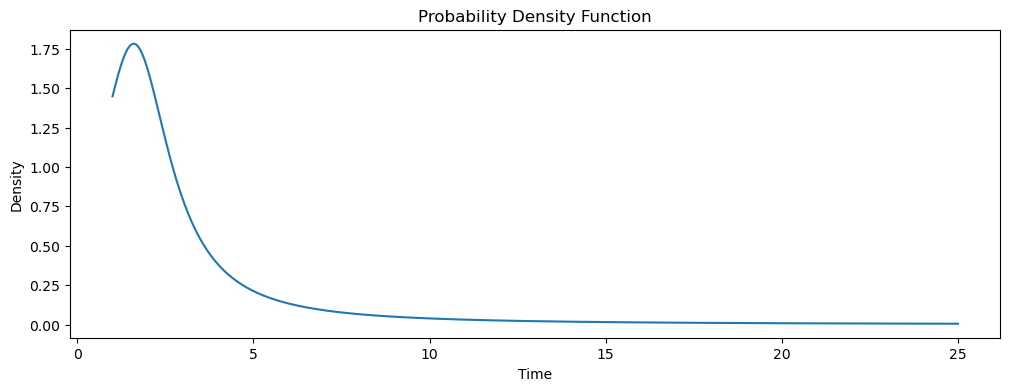

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 1.6
sigma = 1.25
height = 7.
offset = -1.3

# Create time points
t = np.linspace(1, 25, 1000)

# Calculate PDF (derivative of CDF)
pdf = (height / (np.pi * sigma)) * (1 / (1 + ((t - mu)/sigma)**2))

# Plot PDF
plt.figure(figsize=(12, 4))
plt.plot(t, pdf)
plt.title('Probability Density Function')
plt.xlabel('Time')
plt.ylabel('Density')


Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.000 to 6.091')

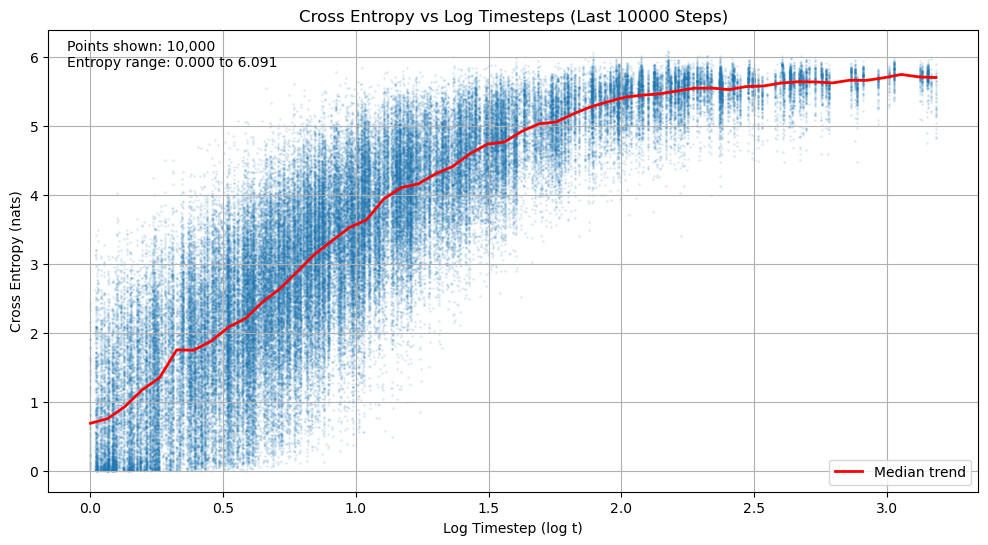

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100000:])
entropy = np.array(scheduler.entropy[-100000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

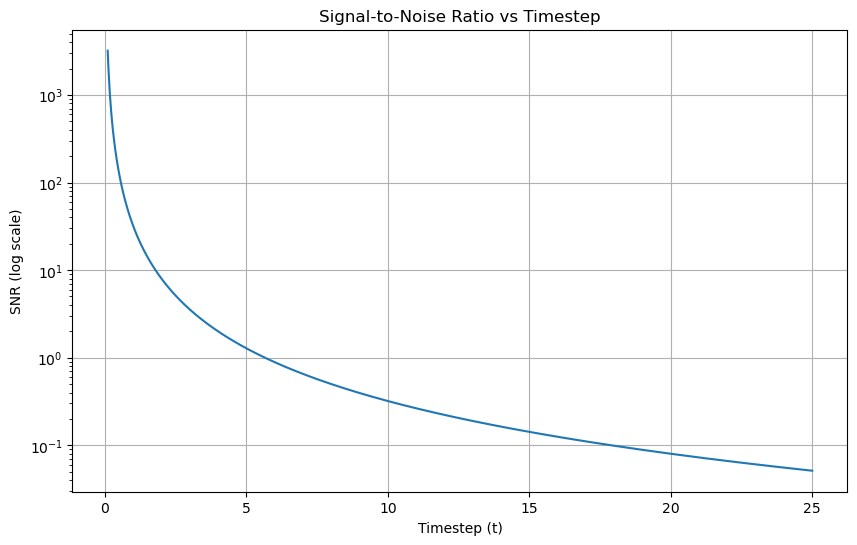

In [51]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 25, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()

In [52]:
def generate_sample(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples using a diffusion model with self-conditioning.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        predicted_tokens: Generated token indices of shape (batch_size, seq_len)
    """
    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps as a 1D sequence
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]

    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            # Concatenate residual stream with conditioning
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1) #normalization factor
            x = x * c_in

            # Forward through model components
            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)

        probs = torch.softmax(logits, dim=-1)
        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)

        # Update conditioning for next step
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        # # Compute derivative and update residual stream
        d = (image - expected_embedding) / timesteps[i] 
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

        
        # d = (expected_embedding - image) / (timesteps[i]**2)
        # image = image - dt * d

    # Final forward pass
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)

    predicted_tokens = torch.argmax(final_logits, dim=2)
    
    return predicted_tokens


def generate_unique_samples(
    model,
    scheduler,
    num_samples,
    lmin=5,
    lmax=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate multiple samples with varying lengths and deduplicate tokens within each sequence.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        num_samples: Number of samples to generate
        lmin: Minimum sequence length
        lmax: Maximum sequence length
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        list[list[int]]: List of sequences, where each sequence contains unique tokens
    """
    unique_sequences = []
    
    for _ in range(num_samples):
        # Sample a random sequence length
        seq_len = torch.randint(low=lmin, high=lmax+1, size=(1,)).item()
        
        # Generate a single sample
        tokens = generate_sample(
            model,
            scheduler,
            batch_size=1,
            seq_len=seq_len,
            n_steps=n_steps,
            t_min=t_min,
            t_max=t_max,
            device=device
        )
        
        # Convert to list and get first sequence
        token_list = tokens[0].cpu().tolist()
        
        # Deduplicate while preserving order
        seen = set()
        unique_tokens = []
        for token in token_list:
            if token not in seen:
                seen.add(token)
                unique_tokens.append(token)
        
        unique_sequences.append(unique_tokens)
    
    return unique_sequences




In [53]:
tokens = generate_sample(
    model,
    scheduler,
    batch_size=3,
    seq_len=15,
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)

In [54]:
sequences = generate_unique_samples(
    model,
    scheduler,
    num_samples=200,
    lmin=5,   # Minimum sequence length
    lmax=200,  # Maximum sequence length
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


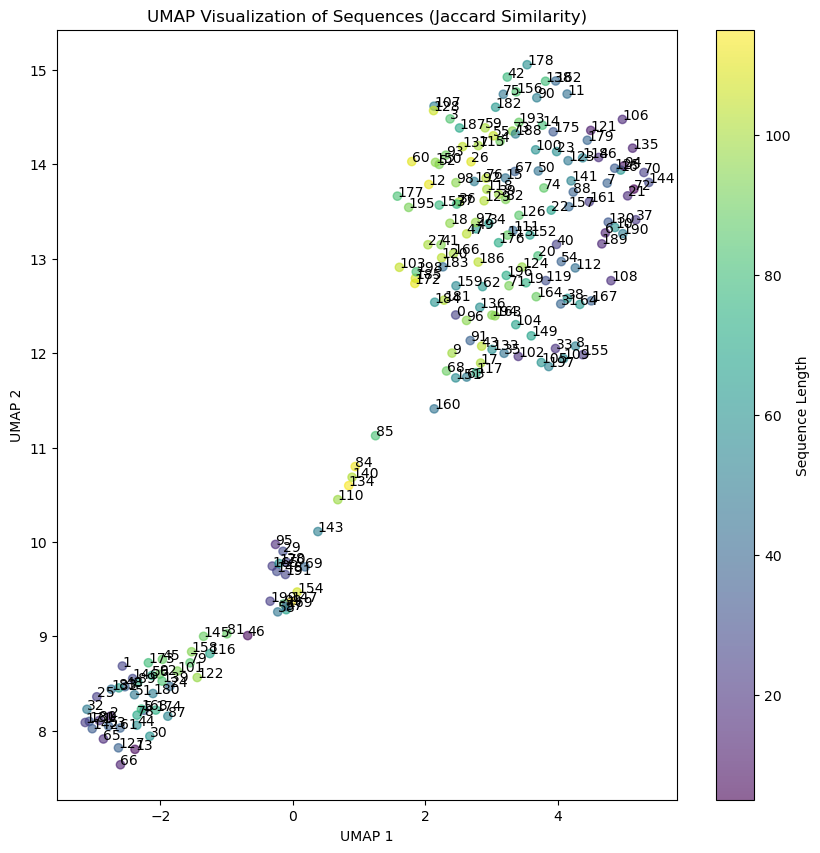

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Binarize sequences
vocab_size = 519
binary_vecs = np.zeros((len(sequences), vocab_size))
for i, seq in enumerate(sequences):
    binary_vecs[i, seq] = 1

# Compute Jaccard distances
distances = pairwise_distances(binary_vecs, metric='jaccard')

# Apply UMAP
umap = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed'
)
embeddings = umap.fit_transform(distances)

# Create plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                     c=[len(seq) for seq in sequences],
                     cmap='viridis',
                     alpha=0.6)

# Add sequence labels
for i, seq in enumerate(sequences):
    plt.annotate(f'{i}', (embeddings[i, 0], embeddings[i, 1]))

plt.colorbar(scatter, label='Sequence Length')
plt.title('UMAP Visualization of Sequences (Jaccard Similarity)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

tensor([34.9998, 24.1775, 18.7868, 15.5559, 13.4014, 11.8606, 10.7028,  9.8000,
         9.0757,  8.4810,  7.9834,  7.5605,  7.1963,  6.8790,  6.5997,  6.3518,
         6.1300,  5.9302,  5.7490,  5.5838,  5.4324,  5.2929,  5.1639,  5.0441,
         4.9325,  4.8280,  4.7299,  4.6376,  4.5504,  4.4679,  4.3896,  4.3150,
         4.2439,  4.1759,  4.1108,  4.0483,  3.9882,  3.9302,  3.8743,  3.8202,
         3.7678,  3.7170,  3.6676,  3.6195,  3.5726,  3.5268,  3.4820,  3.4382,
         3.3953,  3.3531,  3.3116,  3.2708,  3.2306,  3.1909,  3.1517,  3.1129,
         3.0745,  3.0364,  2.9986,  2.9610,  2.9236,  2.8863,  2.8491,  2.8119,
         2.7748,  2.7376,  2.7004,  2.6630,  2.6254,  2.5877,  2.5497,  2.5113,
         2.4726,  2.4335,  2.3940,  2.3539,  2.3133,  2.2720,  2.2300,  2.1873,
         2.1437,  2.0992,  2.0537,  2.0071,  1.9593,  1.9103,  1.8598,  1.8079,
         1.7542,  1.6988,  1.6414,  1.5819,  1.5200,  1.4556,  1.3884,  1.3182,
         1.2446,  1.1673,  1.0859,  1.00

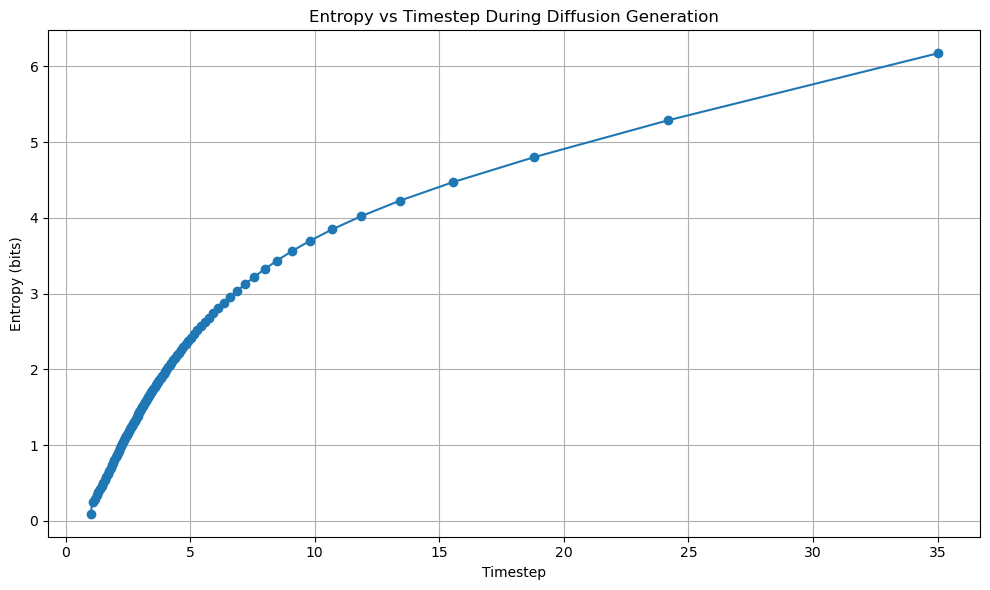

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples and plot entropy against timesteps.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
    """
    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    print(timesteps)
    
    # Initialize storage for entropy values
    entropy_values = []
    timestep_values = []
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]
    
    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    def calculate_entropy(probs):
        """Calculate entropy from probability distribution"""
        # Add small epsilon to avoid log(0)
        eps = 1e-10
        entropy = -torch.sum(probs * torch.log2(probs + eps), dim=-1)
        return entropy.mean().item()

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1)
            x = x * c_in

            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)
        
        # Calculate probabilities and entropy
        probs = torch.softmax(logits, dim=-1)
        entropy = calculate_entropy(probs)
        
        # Store values for plotting
        entropy_values.append(entropy)
        timestep_values.append(timesteps[i].item())

        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)
        
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        d = (image - expected_embedding) / timesteps[i]**2
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

    # Calculate final entropy
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)
        final_probs = torch.softmax(final_logits, dim=-1)
        final_entropy = calculate_entropy(final_probs)

    entropy_values.append(final_entropy)
    timestep_values.append(timesteps[-1].item())

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timestep_values, entropy_values, '-o')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy (bits)')
    plt.title('Entropy vs Timestep During Diffusion Generation')
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    
    return entropy_values, timestep_values

entropy_values, timestep_values = plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=200,
    n_steps=100
)
